# Introduction

Let's say we have some data and we want to know how velocity, movement, and spin rates on fastballs impact the ability for batters to put the ball in play. In this notebook we will consider a Bayesian logistic regression and ML approach to this problem.

# Setup

In [1]:
# OS, misc.
import os
from pathlib import Path
import pickle 
from tqdm import tqdm

# Data analysis
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm

# Bayesian inference
import pymc as pm
import arviz as az
import xarray as xr

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

mpl.rcParams.update({"font.family":"Arial", 
                     "font.size": 8 ,
                     "axes.labelweight": "bold",
                     "axes.titleweight": "bold",
                     "legend.frameon": False,
                     "text.latex.preamble": r'\boldmath'})

# Define colors
red     = np.divide((232, 24, 40),255)
blue    = np.divide((0, 45, 114),255)
skyblue = np.divide((86, 180, 233),255)
blue_cb = np.divide((0, 114, 178),255)
green   = np.divide((0, 158, 115),255)
pink    = np.divide((204, 121, 167),255)
orange  = np.divide((230, 159, 0),255)
grey    = (.5, .5, .5) 

In [2]:
# Data paths
train_dataset = Path("data/InPlay/training.csv")
test_dataset = Path("data/InPlay/deploy.csv")

In [3]:
# Load data
train_data = pd.read_csv(train_dataset)
train_data.head()

,InPlay,Velo,SpinRate,HorzBreak,InducedVertBreak
0,0,95.33,2893.0,10.68,21.33
1,0,94.41,2038.0,17.13,5.77
2,0,90.48,2183.0,6.61,15.39
3,0,93.04,2279.0,9.33,14.57
4,0,95.17,2384.0,6.99,17.62


# Data exploration 

Let's take a look at the data.

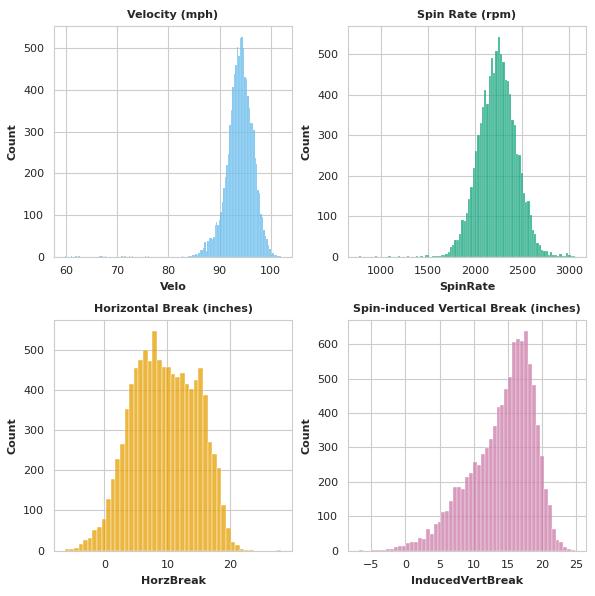

In [4]:
which_columns = train_data.columns.tolist()[1:]
titles = ["Velocity (mph)","Spin Rate (rpm)", "Horizontal Break (inches)", "Spin-induced Vertical Break (inches)"]
with sns.axes_style("whitegrid"):
    # Make figure
    fig, allax = plt.subplots(2,2)#,sharey=True)#sharex=True)
    fig.set_size_inches(6,6)
    
    for (col, ax, clr,titl) in zip(which_columns, allax.ravel(), [skyblue, green, orange, pink],titles):
        sns.histplot(ax=ax, data=train_data,x=col,color=clr)
        ax.set_title(titl,fontsize=8)

    plt.tight_layout()


Out of curiosity, let's see what it looksl ike if we condition on balls in play. 

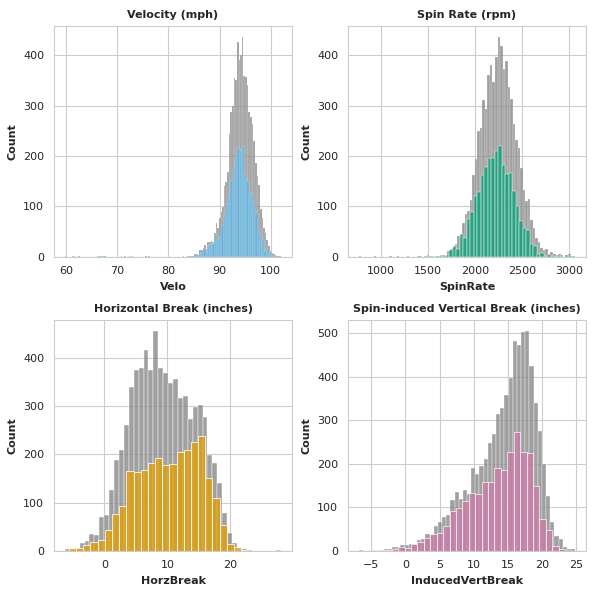

In [5]:
which_columns = train_data.columns.tolist()[1:]
titles = ["Velocity (mph)","Spin Rate (rpm)", "Horizontal Break (inches)", "Spin-induced Vertical Break (inches)"]
with sns.axes_style("whitegrid"):
    # Make figure
    fig, allax = plt.subplots(2,2)#,sharey=True)#sharex=True)
    fig.set_size_inches(6,6)
    
    for (col, ax, clr,titl) in zip(which_columns, allax.ravel(), [skyblue, green, orange, pink],titles):
        sns.histplot(ax=ax, data=train_data.query("InPlay == 1"),x=col,color=clr,zorder=2)
        sns.histplot(ax=ax, data=train_data.query("InPlay == 0"),x=col,color=grey)
        ax.set_title(titl,fontsize=8)

    plt.tight_layout()


This is a lot of data, so it's not surprising that the effects are not obvious from these histograms. In order to understand the data we need to build a model that describes the relationship between the predictors, i.e. pitch parameteres, and the response, which in this case is the play outcome. 

Let's look at how each predictor relates to the outcome, `InPlay`.

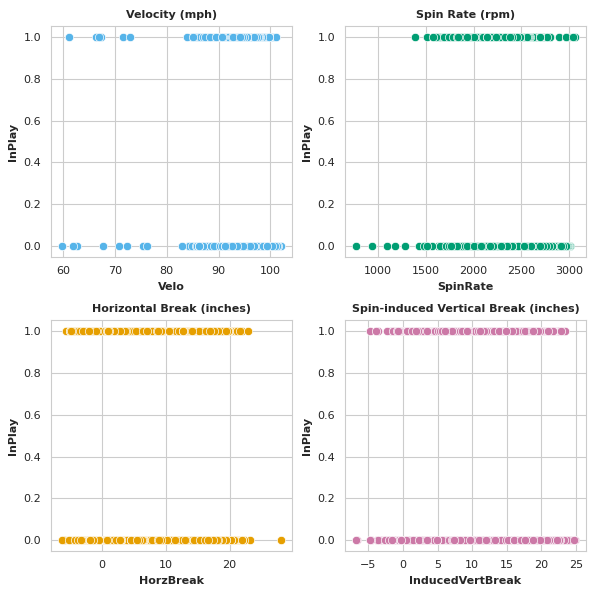

In [6]:
which_columns = train_data.columns.tolist()[1:]
titles = ["Velocity (mph)","Spin Rate (rpm)", "Horizontal Break (inches)", "Spin-induced Vertical Break (inches)"]
with sns.axes_style("whitegrid"):
    # Make figure
    fig, allax = plt.subplots(2,2)#,sharey=True)#sharex=True)
    fig.set_size_inches(6,6)
    
    for (col, ax, clr,titl) in zip(which_columns, allax.ravel(), [skyblue, green, orange, pink],titles):
        sns.scatterplot(ax=ax, data=train_data,x=col,y="InPlay",color=clr,zorder=2)
        ax.set_title(titl,fontsize=8)

    plt.tight_layout()

Unfortunately, from this it seems like the data are not easily separable from a linear model alone. Nonetheless, we will consider the general approach to model selection. 

# Model selection

When thinking about model selection, I first like to think about the specific goals that my model should accomplish. For example, if I only care about prediction and do not care about explanation, I might select an off-the-shelf method, such as a random forest, or perhaps a neural network. While there are ways to dig in to the black-box models to understand feature importance and predictive power, for a problem like this I lean heavily to a statistical modeling approach. In this way, I like to start with what my outcome variable should look like and then work backwards towards the inputs to my model. If we think more like a Bayesian, I would start by thinking of the family of distributions my response falls within, then think about the likelihood function for that data generating process, and finally think about how my priors will impact my model's behavior. 

For this specific model, I know that we want to model the outcome of the play given the parameters of pitches, thus I will choose to model the data using a generalized linear model. For my response, I could select either a probit or logit function for mapping my predictors into class membership (i.e., in play or not). 

Our model looks something like this:

\begin{align}
Y_i | \beta_0, ..., \beta_n & \sim \text{Bernoulli}(\pi_i)\\
log(\frac{\pi_i}{1-\pi_i}) &= \beta_0 +  \beta_1X_{i,1} + ... +  \beta_nX_{i,n}
\end{align}

By selecting a Bayesian approach, we now have the ability to place priors on our parameters. We will use a weakly informative prior (normal distribution here) so that we do not over constrain the model and allow positive and negative coefficients. 

In [7]:
from sklearn.model_selection import train_test_split
from patsy import dmatrices

# Formula
fml = "InPlay ~ 0 + Velo + SpinRate + HorzBreak + InducedVertBreak"

# Design matrices using patsy
y, X = dmatrices(fml, train_data, return_type='dataframe')
X_train_mean = X.mean()
X_train_std  = X.std()
X = (X - X.mean()) / X.std()

# Train test split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.25, random_state=111)

# Save training/validation split
X_train.to_csv(Path("data/InPlay/x_train.csv"),)
y_train.to_csv(Path("data/InPlay/y_train.csv"))
X_validation.to_csv(Path("data/InPlay/x_validation.csv"))
y_validation.to_csv(Path("data/InPlay/y_validation.csv"))

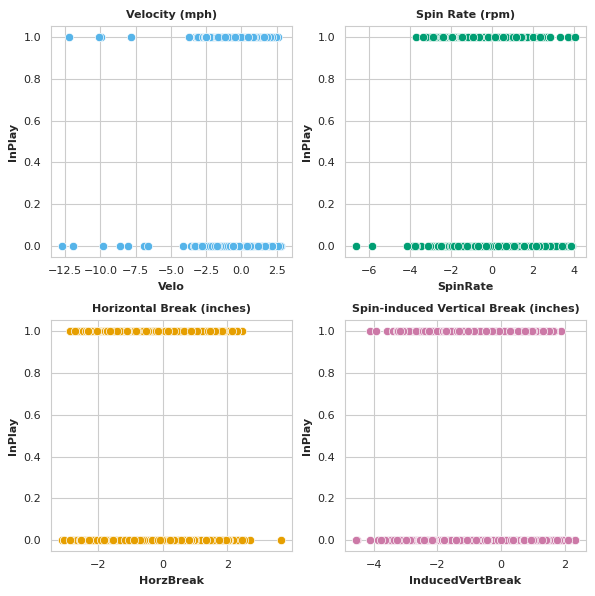

In [8]:
which_columns = train_data.columns.tolist()[1:]
titles = ["Velocity (mph)","Spin Rate (rpm)", "Horizontal Break (inches)", "Spin-induced Vertical Break (inches)"]
with sns.axes_style("whitegrid"):
    # Make figure
    fig, allax = plt.subplots(2,2)#,sharey=True)#sharex=True)
    fig.set_size_inches(6,6)
    
    for (col, ax, clr,titl) in zip(which_columns, allax.ravel(), [skyblue, green, orange, pink],titles):
        sns.scatterplot(ax=ax, data=pd.concat([X_train,y_train],axis=1),x=col,y="InPlay",color=clr,zorder=2)
        ax.set_title(titl,fontsize=8)

    plt.tight_layout()

## Train model

Turns out to be *signficantly* faster to run the inference in a separate file than directly in the notebook

In [12]:
!python utils/train_InPlay.py

Loading data...
Building model...
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, beta2, beta3, beta4]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.


Load trace.

In [13]:
# Get inference data
idata = az.from_netcdf(Path("models/trace_InPlay.nc"))
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

Get model and training data using same functions as those called in `train.py`.

In [14]:
from utils.train_InPlay import get_model, get_train_data

# Get the data
X_train, y_train= get_train_data()

# Get model
model = get_model(X_train, y_train)

RANDOM_SEED = 58
rng = np.random.default_rng(RANDOM_SEED)

Loading data...
Building model...


Visualize the trace for each parameter.

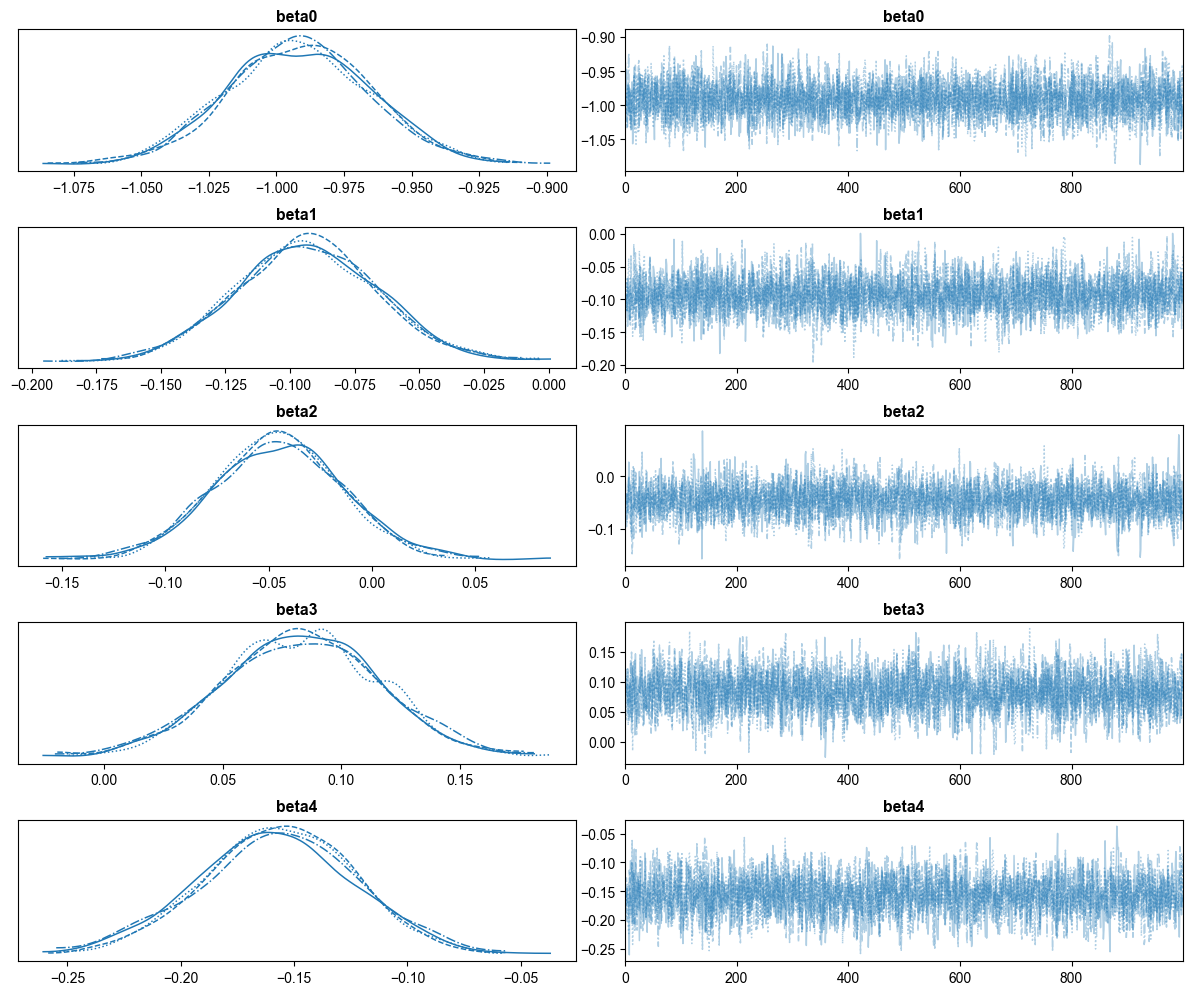

In [15]:
az.plot_trace(idata,var_names=["beta0", "beta1", "beta2", "beta3", "beta4"])
plt.show
plt.tight_layout()

This looks pretty good. Even though we did not sample that many values, we see that there weren't any divergences and the chains all seem to land on the same value. 

## Perform posterior predictive checks

We can sample all of the data but it's quite difficult to interpret this. 

In [16]:
with model:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True,random_seed=rng)

Sampling: [outcome]


<AxesSubplot:xlabel='outcome / outcome'>

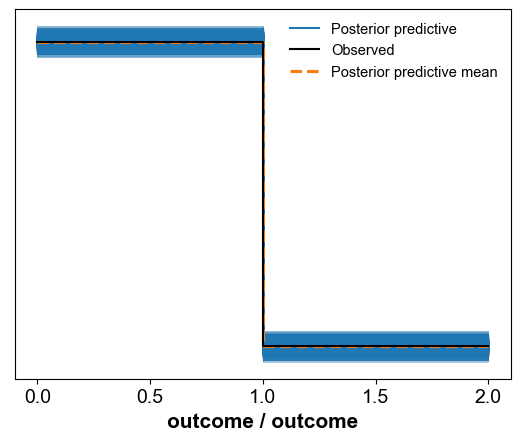

In [17]:
az.plot_ppc(idata)

From this we can see that our model is indeed predicting our binary outcome as we would expect. However, it is difficult to determine the impact of each feature on the model.

## "Counterfactual" Analysis (predictor effects)
 A more informative way to analyze the model is to determine the effect of each individual predictor while holding all other values constant. For this, we will set the values of all other predictors to zero except the one we are interested in. This is sometimes referred to as a *counterfactual plot* such as in the book Statistical Rethinking. 

In [18]:
# Hold predictors at zero except for specific column and plot impact on model
def counterfactual_analysis(col_name: str, x_range: tuple, var_names: dict, model: pm.Model, idata: az.data.inference_data.InferenceData):
    # Get range and new data
    a, b = x_range
    n_samples = 100
    new_array = np.linspace(a,b, n_samples)

    # Make data frame with all zeros
    predict_data = pd.DataFrame(np.zeros((n_samples,len(X.columns))),columns=X.columns)
    predict_data.loc[:, col_name] = new_array

    # Get model and change data    
    with model: 
        # Update data container
        for col in X.columns:
            pm.set_data({var_names[col]: predict_data.loc[:,col].to_numpy()})
        # PPC
        ppc = pm.sample_posterior_predictive(idata,var_names=["p"], random_seed=rng)

    # Get mean of samples
    return ppc

var_names = {"Velo": "velo", "SpinRate": "spin", "HorzBreak": "horz", "InducedVertBreak": "vert"}

Run counterfactual analysis for each column.

In [19]:
ppc_dict = dict(zip(X_train.columns.tolist(), len(X_train.columns)*[None]))
for col in X.columns:
    ppc = counterfactual_analysis(col, (-4, 4), var_names, model, idata)
    ppc_dict[col] = ppc

Sampling: []


Sampling: []


Sampling: []


Sampling: []


Visualize results

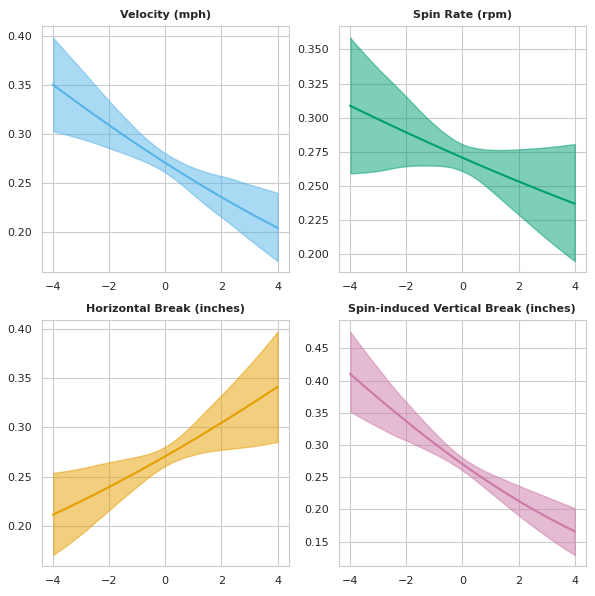

In [20]:
which_columns = X_train.columns.tolist()
titles = ["Velocity (mph)","Spin Rate (rpm)", "Horizontal Break (inches)", "Spin-induced Vertical Break (inches)"]
with sns.axes_style("whitegrid"):
    
    # Make figure
    fig_counterfact, allax = plt.subplots(2,2)#,sharey=True)#sharex=True)
    fig_counterfact.set_size_inches(6,6)
    
    for (col, ax, clr,titl) in zip(which_columns, allax.ravel(), [skyblue, green, orange, pink],titles):
        # sns.scatterplot(ax=ax, data=pd.concat([X_train,y_train],axis=1),x=col,y="InPlay",color=clr,zorder=2)
        ppc = ppc_dict[col]
        ax.plot(ppc["constant_data"][var_names[col]] , ppc["posterior_predictive"]["p"].mean(("chain","draw")),color=clr)
        az.plot_hdi(ppc["constant_data"][var_names[col]], ppc["posterior_predictive"]["p"],ax=ax,color=clr)
        ax.set_title(titl,fontsize=8)

    plt.tight_layout()

We can interpret these plots as the impact of the predictor given that we hold all other predictors constant. Since the data are standardized, we are basically asking what the impact of a single predictor is if the other predictors are exactly average. These are interesting because from a baseball persepective they are mostly intuitive and obvious, except for horizontal break. Basically, the more spin, velocity, and vertical break that a pitcher has, the lower the probability of the ball being put in play. The interesting thing is that horizontal break seems to have the opposite effect. This could be one of two things: either the model is just wrong in general, OR the model is fine and there is some effect that when the ball moves too much, the batter can more easily distinguish the ball path and makes better predictions for hitting. Before we lean on these results too much let's look at the model performance. 

## Model accuracy

Load validation data.

In [23]:
from utils.train_InPlay import get_validation_data

# def get_validation_data():
#     # Load data
#     print("Loading data...")
#     X = pd.read_csv(Path("data/x_validation.csv")).drop(["Unnamed: 0"],axis=1)
#     y = pd.read_csv(Path("data/y_validation.csv")).drop(["Unnamed: 0"],axis=1)
#     return X, y

# Get test data
X_validation, y_validation = get_validation_data()

Loading data...


Switch out data for new unseen data and sample. 

In [24]:
with model:
    # Update predictors
    for col in X_validation.columns:
            pm.set_data({var_names[col]: X_validation.loc[:,col].to_numpy()})
    # Make predictions on validation set       
    idata = pm.sample_posterior_predictive(idata, var_names=["p"],
        return_inferencedata=True,
        predictions=True,
        extend_inferencedata=True,
        random_seed=rng,
    )

Sampling: []


In [25]:
idata["predictions"]

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 1000, p_dim_2: 2499)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * p_dim_2  (p_dim_2) int64 0 1 2 3 4 5 6 ... 2493 2494 2495 2496 2497 2498
Data variables:
    p        (chain, draw, p_dim_2) float64 0.2569 0.2729 ... 0.3444 0.2243
Attributes:
    created_at:                 2022-12-03T00:48:24.417414
    arviz_version:              0.13.0
    inference_library:          pymc
    inference_library_version:  4.4.0

Let's visualize what the probability values are for each instance within the validation set. The black represents instances in which `InPlay == 0` and the blue is `InPlay == 1`. The red dots are the probability of the ball being put in play. 

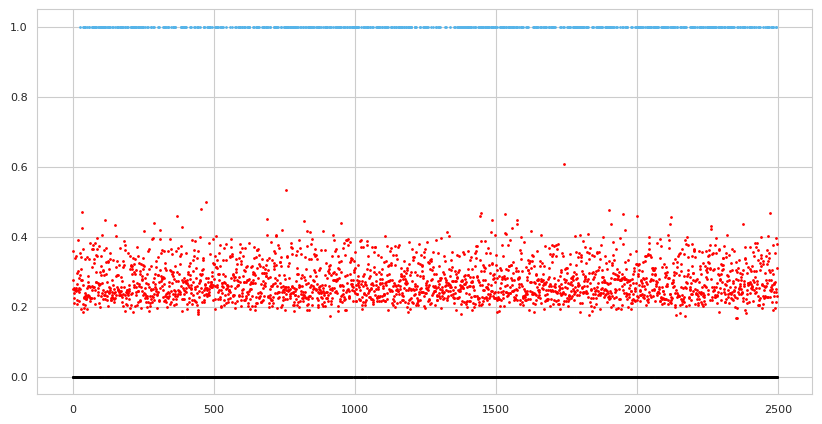

In [26]:
with sns.axes_style("whitegrid"):
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot()

    ax.scatter(x=y_validation.query("InPlay == 0").index.to_numpy(),y=y_validation.query("InPlay == 0").InPlay.to_numpy(),color="black",s=1)
    ax.scatter(x=y_validation.query("InPlay == 1").index.to_numpy(),y=y_validation.query("InPlay == 1").InPlay.to_numpy(),color=skyblue,s=1)
    ax.scatter(x=idata["predictions"]["p_dim_2"],y=idata["predictions"]["p"].mean(("chain","draw")),color='r',s=1)

In [27]:
y_validation["Prob_PyMC"] = idata["predictions"]["p"].mean(("chain","draw"))
y_validation["Predict_PyMC"] = np.array(idata["predictions"]["p"].mean(("chain","draw")),dtype="int")
y_validation.sample(5)

,InPlay,Prob_PyMC,Predict_PyMC
2415,0.0,0.269552,0
1155,1.0,0.243889,0
125,1.0,0.331342,0
2214,0.0,0.248310,0
683,0.0,0.306851,0


## Comparison with `sklearn` logistic regression

Let's use an off-the-shelf model to see how our Bayesian implementation compares. 

In [28]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0).fit(X_train.to_numpy(),y_train.to_numpy().ravel())
res = clf.predict_proba(X_validation.to_numpy())[:,1]

If we visualize the data like before, we can see that for the most part the green dots (sklearn) are very close to the red dots (Bayesian). There might be slight differences due to the internals of the sklearn model (e.g., weight penalization), but for the most part the look the same. 

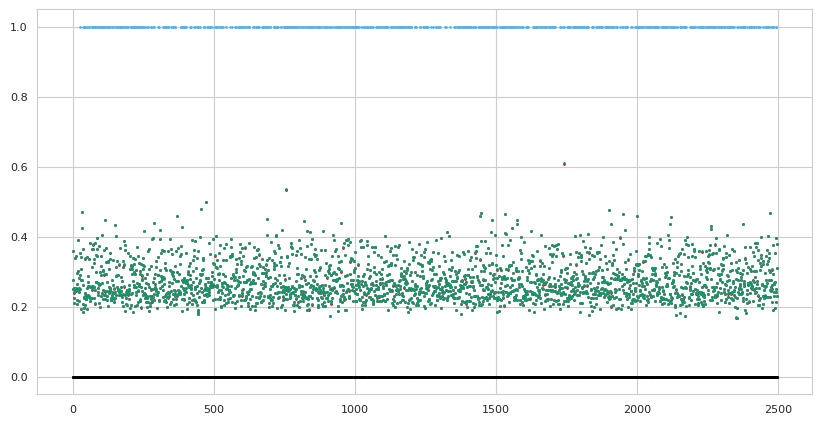

In [29]:
with sns.axes_style("whitegrid"):
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot()

    ax.scatter(x=y_validation.query("InPlay == 0").index.to_numpy(),y=y_validation.query("InPlay == 0").InPlay.to_numpy(),color="black",s=1)
    ax.scatter(x=y_validation.query("InPlay == 1").index.to_numpy(),y=y_validation.query("InPlay == 1").InPlay.to_numpy(),color=skyblue,s=1)
    ax.scatter(x=idata["predictions"]["p_dim_2"],y=idata["predictions"]["p"].mean(("chain","draw")),color='r',s=1)
    ax.scatter(x=idata["predictions"]["p_dim_2"],y=res,color=green,s=1)


## Model accuracy

In [30]:
print("Bayesian model accuracy: {:.2f}%".format(np.sum((y_validation["InPlay"] == y_validation["Predict_PyMC"]))/len(y_validation)*100))
print("Sklearn model accuracy: {:.2f}%".format(clf.score(X_validation.to_numpy(),y_validation["InPlay"].to_numpy())*100))

Bayesian model accuracy: 73.47%
Sklearn model accuracy: 73.43%


We can see from the accuracies that models are nearly identical in their prediction accuracy. The difference is really in our ability to test the impact of the predictors on our model while also preserving estimates of uncertainty. Since we can't do the exact same as before, we can take a slightly different approach and pull out a method from our intepretable ML bag of tricks. For this we will use consider the shapley value approach [(reference)](https://christophm.github.io/interpretable-ml-book/shapley.html). 

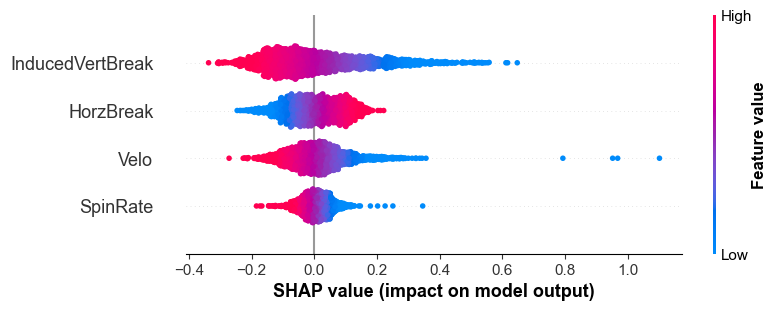

In [31]:
import shap

explainer = shap.explainers.Linear(clf, X_train.to_numpy(),link=shap.links.logit)
shap_values = explainer(X_validation)
shap.plots.beeswarm(shap_values)


This is interesting because it basically shows the same thing as our earlier figure on "counterfactual plots" showed. I'll add it below just for easier reference. 

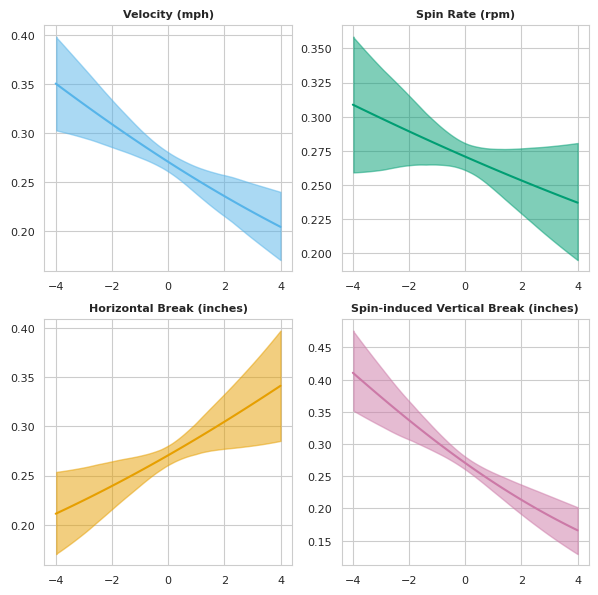

In [32]:
fig_counterfact

Now let's apply our model to the unlabeled `deploy.csv` dataset.

In [33]:
# Load data
X_test = pd.read_csv(test_dataset)

X_test = X_test.dropna(axis=0)

# Standardize using train mean and std
X_test = (X_test - X_train_mean) / X_train_std


with model:
    # Update predictors
    for col in X_test.columns:
            pm.set_data({var_names[col]: X_test.loc[:,col].to_numpy()})
    # Make predictions on validation set       
    idata_deploy = pm.sample_posterior_predictive(idata,var_names=["p"],
        return_inferencedata=True,
        predictions=True,
        extend_inferencedata=False,
        random_seed=rng,
    )


Sampling: []


In [34]:
predicted_InPlay = np.array(idata_deploy["predictions"].mean(("chain","draw"))["p"] > .5,dtype="int")
print("Predicted number of balls in play: {}/{}".format(np.sum(predicted_InPlay), len(predicted_InPlay)))

Predicted number of balls in play: 3/9987


Hmm.. thats a little suspicious. But without the labels we can't know how accurate this is. Just to make sure everything is ok, let's check the distributions of our original data before standardizing.

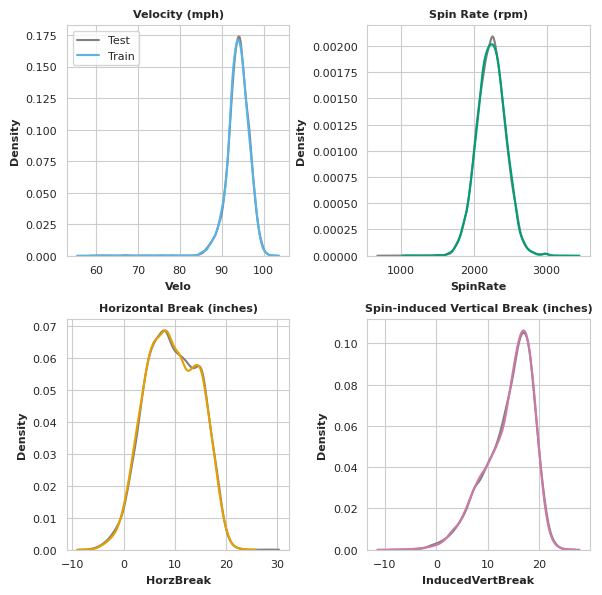

In [36]:
# Load original csv files
train_data = pd.read_csv(train_dataset)
test_data  = pd.read_csv(test_dataset)

which_columns = train_data.columns.tolist()[1:]
titles = ["Velocity (mph)","Spin Rate (rpm)", "Horizontal Break (inches)", "Spin-induced Vertical Break (inches)"]
with sns.axes_style("whitegrid"):
    # Make figure
    fig, allax = plt.subplots(2,2)#,sharey=True)#sharex=True)
    fig.set_size_inches(6,6)
    
    for (col, ax, clr,titl) in zip(which_columns, allax.ravel(), [skyblue, green, orange, pink],titles):
        sns.kdeplot(ax=ax,data=train_data,x=col,color=grey,label="Test")
        sns.kdeplot(ax=ax, data=test_data,x=col,color=clr,label="Train")
        ax.set_title(titl,fontsize=8)
    
    allax[0,0].legend(frameon=True)
    plt.tight_layout()

# Traditional Machine Learning Approach

Let's say that we want to improve the accuracy of our model by finding some other approach to deal with the poor separability in our model. As an alternate approach to what we were doing before, we might consider an off-the-shelf ML model. 

In [37]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Cross validation
rfc = RandomForestClassifier() # Defaults
scores = cross_val_score(rfc, X_train.to_numpy(), y_train.to_numpy().ravel(), cv=5)
print("Mean cross-validation classification accuracy: {:.2f}".format(scores.mean()))

# Train full model
rfc = RandomForestClassifier(n_estimators=10).fit(X_train.to_numpy(), y_train.to_numpy().ravel())
print("Accuracy on validation set: {:.2f}".format(rfc.score(X_validation.to_numpy(),y_validation["InPlay"].to_numpy().ravel())))

Mean cross-validation classification accuracy: 0.71
Accuracy on validation set: 0.71


Interestingly we did not gain much in terms of accuracy on our training set. Let's try a different method just for a sanity check. 

In [38]:
from sklearn.ensemble import GradientBoostingClassifier

# Cross validation
gbc = GradientBoostingClassifier() # Defaults
scores = cross_val_score(gbc, X_train.to_numpy(), y_train.to_numpy().ravel(), cv=5)
print("Mean cross-validation classification accuracy: {:.2f}".format(scores.mean()))

# Train full model
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train.to_numpy(), y_train.to_numpy().ravel())
print("Accuracy on validation set: {:.2f}".format(gbc.score(X_validation.to_numpy(),y_validation["InPlay"].to_numpy().ravel())))

Mean cross-validation classification accuracy: 0.72
Accuracy on validation set: 0.73


In [39]:
gbc_predict = np.sum(gbc.predict(X_test.to_numpy()))
print("Predicted number of balls in play: {}/{}".format(np.sum(gbc_predict).astype("int"), len(X_test)))

Predicted number of balls in play: 62/9987


# Conclusions

In this notebook, our goal was to consider the impact of each pitch feature&mdash;velocity, spin rate, horizontal break, and vertical break&mdash;on whether the ball is put in play or not. Given the nature of the outcome variable, our approach was to consider a logistic regression model. The first model was specifically a Bayesian approach to a logistic regression model. For simplicity and interpretability, we assumed a linear model with no interaction terms in the predictors. In reality, there are some interesting ineractions to consider, such as `spin:velocity`, however, some of the values are alreay correlated in the physics. For example, while some of the pitch behavior, such as a fastball's ride (or hop), is also driven by the mechanics and release, the break of the ball is directly impacted by the spin and velocity of the pitch. Nonetheless, since we only have the four predictors, we will rely only on those values for our predictions. Overall, the model had good convergence with no divergences for any of the parameters. The prediction accuracy on the train/validation set was ~$70\%$ overall. When compared the an off-the-shelf logistic regression model from sklearn (second model), the results were nearly identical. The advantage of the Bayesian model was our ability to evaluate the effect of each predictor on the outcome using our so-called "counterfactual" plots. However, we were able to achieve similar interpretability using shapley values on our off-the-shelf model. 

A second overall approach to this problem is a standard machine learning approach. For this I simply considered some standard ML approaches and evaluated their performance using cross-validation and prediction on the validation set. Interestingly, the model accuracies were quite similar to our logistic regression models. While is an interesting and sometimes useful approach, I prefer the first approach and thus did not dive deeper in to exploring this direction.

# Future work

I think an interesting next direction would be to add a BART model to possibly capture some of the nonlinearity while retaining some of the explanatory power of a Bayesian model. 

# Bayesian Additive Regression Trees (BART)

Let's try using a BART model. This allows for us to capture some of the nonlinearity but will *hopefully* retain some of the interpretability of other Bayesian methods. 

In [46]:
import pymc_bart as pmb

with pm.Model() as bart_model:
        # BART model
        data = pm.Data("data",X_train,mutable=True)
        mu = pmb.BART("mu",X=data,Y=y_train["InPlay"],m=100)#,inv_link="logistic")
        # Invlogit
        p = pm.Deterministic("p",pm.math.invlogit(np.abs(mu)))
        # Outcome
        outcome = pm.Bernoulli("outcome",p=p,observed=y_train["InPlay"])

In [47]:
with bart_model: 
        idata = pm.sample(2000,chains=4,return_inferencedata=True, idata_kwargs=dict(log_likelihood=False))


Multiprocess sampling (4 chains in 4 jobs)
PGBART: [mu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 840 seconds.


Plot partial dependence plot. Similar to our counterfactual plots from before. 

hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


array([<AxesSubplot:xlabel='Velo'>, <AxesSubplot:xlabel='SpinRate'>,
       <AxesSubplot:xlabel='HorzBreak'>,
       <AxesSubplot:xlabel='InducedVertBreak'>], dtype=object)

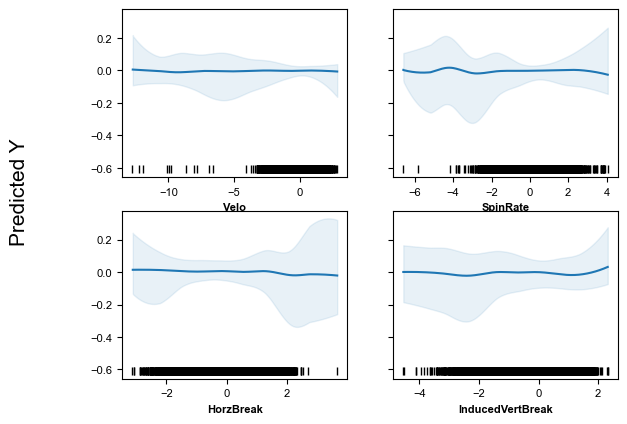

In [48]:
pmb.plot_dependence(mu, X=X_train, Y=y_train, grid=(2, 2))#, var_discrete=[3]);


This is not what I would have expected. It seems like either we have not tuned the model appropriately or we just set the problem up completely wrong... TBD

In [53]:
with bart_model:
    # Update predictors
    pm.set_data({"data": X_validation.to_numpy()})
    # Make predictions on validation set       
    idata = pm.sample_posterior_predictive(idata, var_names=["p"],
        return_inferencedata=True,
        predictions=True,
        extend_inferencedata=True,
        random_seed=rng,
    )

Sampling: [mu]


In [55]:
idata

Inference data with groups:
	> posterior
	> predictions
	> sample_stats
	> observed_data
	> constant_data
	> predictions_constant_data